# Granger Causality with Google Trends - Did `itaewon class` cause `โคชูจัง`?

In [1]:
from pytrends.request import TrendReq
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import warnings
warnings.filterwarnings('ignore')
import matplotlib
matplotlib.rc('font', family='Ayuthaya') # MacOS

## 1. Get trend objects with thailand offset

In [2]:
#get trend objects with thailand offset 7*60 = 420 minutes
trend = TrendReq(hl='th-TH', tz=420)

In [3]:
#compare 2 keywords
kw_list = ['โคชูจัง','itaewon class']
trend.build_payload(kw_list, geo='TH',timeframe='2020-01-01 2020-04-30')
df = trend.interest_over_time().iloc[:,:2]
df.head()

,โคชูจัง,itaewon class
date,,
2020-01-01,2,0
2020-01-02,1,0
2020-01-03,1,0
2020-01-04,1,0
2020-01-05,1,0


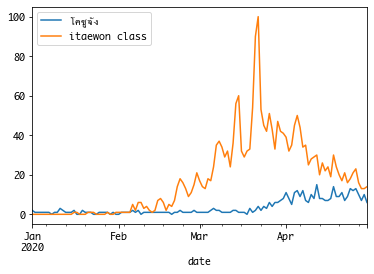

In [4]:
df.plot()

## 2. Stationarity check: Augmented Dickey-Fuller Test

In [5]:
from statsmodels.tsa.stattools import adfuller

In [6]:
#test for stationarity with augmented dickey fuller test
def unit_root(name,series):
    signif=0.05
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0],4),'pvalue':round(r[1],4),'n_lags':round(r[2],4),'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val,lenght=6): 
        return str(val).ljust(lenght)
    print(f'Augmented Dickey-Fuller Test on "{name}"')
    print('-'*47)
    print(f'Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f'Observation           = {output["n_obs"]}')
    print(f'Significance Level    = {signif}')
    print(f'Test Statistic        = {output["test_statistic"]}')
    print(f'No. Lags Chosen       = {output["n_lags"]}')
    for key,val in r[4].items():
        print(f'Critical value {adjust(key)} = {round(val,3)}')
    if p_value <= signif:
        print(f'=> P-Value = {p_value}. Rejecting Null Hypothesis.')
        print(f'=> Series is Stationary.')
    else:
        print(f'=> P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.')
        print(f'=> "{name}" is Non-Stationary.')

2.1. 'โคชูจัง': unit root test

In [7]:
name = 'โคชูจัง'
series = df.iloc[:,0]
unit_root(name,series)

Augmented Dickey-Fuller Test on "โคชูจัง"
-----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Observation           = 107
Significance Level    = 0.05
Test Statistic        = -0.4375
No. Lags Chosen       = 13
Critical value 1%     = -3.493
Critical value 5%     = -2.889
Critical value 10%    = -2.581
=> P-Value = 0.9036. Weak evidence to reject the Null Hypothesis.
=> "โคชูจัง" is Non-Stationary.


2.2. 'itaewon class': unit root test

In [8]:
name = 'itaewon class'
series = df.iloc[:,1]
unit_root(name,series)

Augmented Dickey-Fuller Test on "itaewon class"
-----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Observation           = 113
Significance Level    = 0.05
Test Statistic        = -1.3504
No. Lags Chosen       = 7
Critical value 1%     = -3.49
Critical value 5%     = -2.887
Critical value 10%    = -2.581
=> P-Value = 0.6058. Weak evidence to reject the Null Hypothesis.
=> "itaewon class" is Non-Stationary.


- 'โคชูจัง' and 'itaewon class' are not significant
- So, we can not reject Null Hypothesis

## 3. Taking 1st Difference

In [9]:
diff_df = df.diff(1).dropna()

3.1. 1st Difference of 'โคชูจัง': unit root test

In [10]:
name = 'โคชูจัง'
series = diff_df.iloc[:,0]
unit_root(name,series)

Augmented Dickey-Fuller Test on "โคชูจัง"
-----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Observation           = 107
Significance Level    = 0.05
Test Statistic        = -2.8133
No. Lags Chosen       = 12
Critical value 1%     = -3.493
Critical value 5%     = -2.889
Critical value 10%    = -2.581
=> P-Value = 0.0564. Weak evidence to reject the Null Hypothesis.
=> "โคชูจัง" is Non-Stationary.


3.2. 1st Difference of 'itaewon class': unit root test

In [11]:
name = 'itaewon class'
series = diff_df.iloc[:,1]
unit_root(name,series)

Augmented Dickey-Fuller Test on "itaewon class"
-----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Observation           = 113
Significance Level    = 0.05
Test Statistic        = -4.5131
No. Lags Chosen       = 6
Critical value 1%     = -3.49
Critical value 5%     = -2.887
Critical value 10%    = -2.581
=> P-Value = 0.0002. Rejecting Null Hypothesis.
=> Series is Stationary.


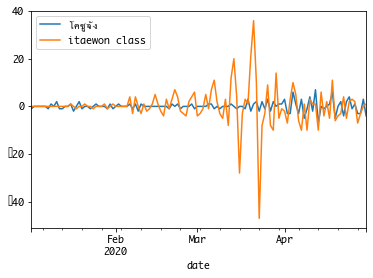

In [12]:
diff_df.plot()

- 1st Difference of 'itaewon class' is significant.
- 1st Difference of 'โคชูจัง' is not significant.

## 4. Taking 2nd Difference

In [13]:
diff_df2 = df.diff(2).dropna()

2st Difference of 'โคชูจัง': unit root test

In [14]:
name = 'โคชูจัง'
series = diff_df2.iloc[:,0]
unit_root(name,series)

Augmented Dickey-Fuller Test on "โคชูจัง"
-----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Observation           = 107
Significance Level    = 0.05
Test Statistic        = -2.9325
No. Lags Chosen       = 11
Critical value 1%     = -3.493
Critical value 5%     = -2.889
Critical value 10%    = -2.581
=> P-Value = 0.0417. Rejecting Null Hypothesis.
=> Series is Stationary.


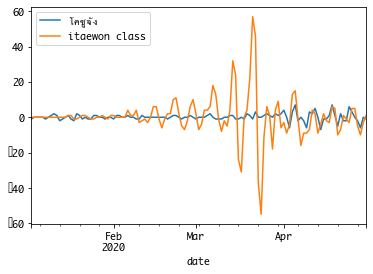

In [15]:
diff_df2.plot()

- 2nd Difference of 'โคชูจัง' is significant.

## 5. Find Lag length

In [16]:
import numpy as np
import statsmodels.tsa.api as smt

In [17]:
df_test = diff_df[['itaewon class']].join(diff_df2[['โคชูจัง']], how='outer').dropna()

In [18]:
# make a VAR model
model = smt.VAR(df_test)

/Users/benyapa/cto-ds-search-modelling/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [19]:
res = model.select_order(maxlags=None)

In [20]:
print(res.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        5.783       5.833       324.6       5.803
1        5.822       5.973       337.6       5.883
2        5.668       5.920       289.6       5.770
3        5.680       6.032       293.2       5.823
4        5.362       5.814       213.3       5.545
5        5.218      5.771*       184.9       5.442
6        5.274       5.927       195.6       5.539
7        5.129       5.883       169.5      5.434*
8        5.114       5.969       167.3       5.461
9        5.168       6.123       177.0       5.555
10       5.213       6.268       185.5       5.640
11       5.108       6.264       167.6       5.576
12      5.065*       6.322      161.3*       5.574
13       5.084       6.441       165.1       5.634
--------------------------------------------------


## 6. Granger causality test

In [21]:
from statsmodels.tsa.stattools import grangercausalitytests

In [22]:
def granger_causation_matrix(data, variables,test,verbose=False):
    x = pd.DataFrame(np.zeros((len(variables),len(variables))), columns=variables,index=variables)
    for c in x.columns:
        for r in x.index:
            test_result = grangercausalitytests(data[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: 
                print(f'Y = {r}, X= {c},P Values = {p_values}')
            min_p_value = np.min(p_values)
            x.loc[r,c] = min_p_value
    x.columns = [var + '_x' for var in variables]
    x.index = [var + '_y' for var in variables]
    return x

In [23]:
# nobs is number of observation
nobs = len(df_test.index)

In [24]:
# maxlag is the maximum lag that is possible number
maxlag = round(12*(nobs/100.)**(1/4.))

In [25]:
data = df_test
variables = df_test.columns

#### 6.1. SSR based F test

In [26]:
test = 'ssr_ftest'
ssr_ftest = granger_causation_matrix(data, variables, test)
ssr_ftest['test'] = 'ssr_ftest'

#### 6.2. SSR based chi2 test

In [27]:
test = 'ssr_chi2test'
ssr_chi2test = granger_causation_matrix(data, variables, test)
ssr_chi2test['test'] = 'ssr_chi2test'

#### 6.3. Likelihood ratio test

In [28]:
test = 'lrtest'
lrtest = granger_causation_matrix(data, variables, test)
lrtest['test'] = 'lrtest'

#### 6.4. Parameter F test

In [29]:
test = 'params_ftest'
params_ftest = granger_causation_matrix(data, variables, test)
params_ftest['test'] = 'params_ftest'

In [30]:
frames = [ssr_ftest, ssr_chi2test, lrtest, params_ftest]

In [31]:
all_test = pd.concat(frames)

In [32]:
all_test

,itaewon class_x,โคชูจัง_x,test
itaewon class_y,1.0000,0.3401,ssr_ftest
โคชูจัง_y,0.0052,1.0000,ssr_ftest
itaewon class_y,1.0000,0.2695,ssr_chi2test
โคชูจัง_y,0.0001,1.0000,ssr_chi2test
itaewon class_y,1.0000,0.2890,lrtest
โคชูจัง_y,0.0007,1.0000,lrtest
itaewon class_y,0.0000,0.3401,params_ftest
โคชูจัง_y,0.0052,0.0000,params_ftest


- "itaewon class" caused "โคชูจัง" 
- But "โคชูจัง"  didn’t caused "itaewon class"
- So,"itaewon class" and "โคชูจัง" are Unidirectional Causality

# What's about chicken and eggs?

## 1. Get data from csv file

In [33]:
#chicken and eggs
chickeggs = pd.read_csv('chickeggs.csv')

In [34]:
chickeggs

,year,chic,egg
0,1930,468491,3581
1,1931,449743,3532
2,1932,436815,3327
3,1933,444523,3255
4,1934,433937,3156
...,...,...,...
70,2000,434687,7060
71,2001,441089,7174
72,2002,438948,7271
73,2003,448748,7289


In [35]:
df = chickeggs.iloc[:,1:]
df['chic'] = df.chic /  df.chic[0]
df['egg'] = df.egg /  df.egg[0]

In [36]:
df = df[['chic','egg']]

In [37]:
df

,chic,egg
0,1.000000,1.000000
1,0.959982,0.986317
2,0.932387,0.929070
3,0.948840,0.908964
4,0.926244,0.881318
...,...,...
70,0.927845,1.971516
71,0.941510,2.003351
72,0.936940,2.030438
73,0.957858,2.035465


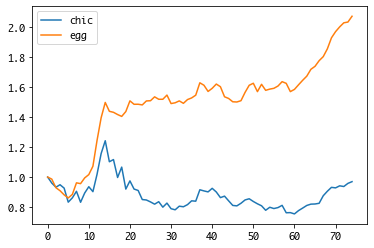

In [38]:
df.plot()

## 2. Stationarity check: Augmented Dickey-Fuller Test

2.1. 'egg': unit root test

In [39]:
name = 'egg'
series = df.iloc[:,0]
unit_root(name,series)

Augmented Dickey-Fuller Test on "egg"
-----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Observation           = 70
Significance Level    = 0.05
Test Statistic        = -2.6729
No. Lags Chosen       = 4
Critical value 1%     = -3.527
Critical value 5%     = -2.904
Critical value 10%    = -2.589
=> P-Value = 0.0788. Weak evidence to reject the Null Hypothesis.
=> "egg" is Non-Stationary.


2.2. 'chic': unit root test

In [40]:
name = 'chic'
series = df.iloc[:,1]
unit_root(name,series)

Augmented Dickey-Fuller Test on "chic"
-----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Observation           = 73
Significance Level    = 0.05
Test Statistic        = -0.809
No. Lags Chosen       = 1
Critical value 1%     = -3.523
Critical value 5%     = -2.902
Critical value 10%    = -2.588
=> P-Value = 0.8165. Weak evidence to reject the Null Hypothesis.
=> "chic" is Non-Stationary.


## 3. Taking 1st Difference

In [41]:
diff_df = df.diff(1).dropna()

In [42]:
diff_df

,chic,egg
1,-0.040018,-0.013683
2,-0.027595,-0.057247
3,0.016453,-0.020106
4,-0.022596,-0.027646
5,-0.093874,-0.020944
...,...,...
70,-0.003498,0.041329
71,0.013665,0.031835
72,-0.004570,0.027087
73,0.020918,0.005027


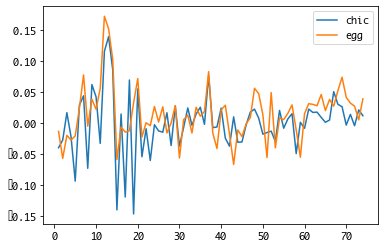

In [43]:
diff_df.plot()

3.1. 1st Difference of 'egg': unit root test

In [44]:
name = 'egg'
series = diff_df.iloc[:,0]
unit_root(name,series)

Augmented Dickey-Fuller Test on "egg"
-----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Observation           = 71
Significance Level    = 0.05
Test Statistic        = -4.4793
No. Lags Chosen       = 2
Critical value 1%     = -3.526
Critical value 5%     = -2.903
Critical value 10%    = -2.589
=> P-Value = 0.0002. Rejecting Null Hypothesis.
=> Series is Stationary.


3.2. 1st Difference of 'chic': unit root test

In [45]:
name = 'chic'
series = diff_df.iloc[:,1]
unit_root(name,series)

Augmented Dickey-Fuller Test on "chic"
-----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Observation           = 73
Significance Level    = 0.05
Test Statistic        = -5.6382
No. Lags Chosen       = 0
Critical value 1%     = -3.523
Critical value 5%     = -2.902
Critical value 10%    = -2.588
=> P-Value = 0.0. Rejecting Null Hypothesis.
=> Series is Stationary.


## 4. Find Lag length

In [46]:
# make a VAR model
model = smt.VAR(diff_df)

/Users/benyapa/cto-ds-search-modelling/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [47]:
res = model.select_order(maxlags=None)

In [48]:
print(res.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -12.85      -12.78   2.628e-06      -12.82
1      -13.11*     -12.90*  2.032e-06*     -13.03*
2       -13.04      -12.70   2.177e-06      -12.90
3       -13.00      -12.52   2.275e-06      -12.81
4       -12.99      -12.38   2.284e-06      -12.75
5       -13.03      -12.28   2.214e-06      -12.73
6       -12.95      -12.06   2.415e-06      -12.60
7       -12.83      -11.81   2.730e-06      -12.43
8       -12.83      -11.68   2.742e-06      -12.38
9       -12.75      -11.46   3.007e-06      -12.24
10      -12.89      -11.46   2.663e-06      -12.33
11      -12.89      -11.32   2.710e-06      -12.27
--------------------------------------------------


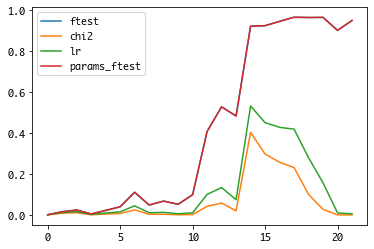

In [49]:
#find the optimal lag
lags = list(range(1,23))
res = grangercausalitytests(diff_df, maxlag=lags, verbose=False)
p_values = []
for i in lags:
    p_values.append({'maxlag':i,
                    'ftest':res[i][0]['ssr_ftest'][1], 
                    'chi2':res[i][0]['ssr_chi2test'][1],
                    'lr':res[i][0]['lrtest'][1],
                    'params_ftest':res[i][0]['params_ftest'][1],})
p_df = pd.DataFrame(p_values)
p_df.iloc[:,1:].plot()

## 5. Granger causality test

In [50]:
# nobs is number of observation
nobs = len(diff_df.index)

In [51]:
# maxlag is the maximum lag that is possible number
maxlag = round(12*(nobs/100.)**(1/4.))

In [52]:
data = diff_df
variables = diff_df.columns

#### 5.1. SSR based F test

In [53]:
test = 'ssr_ftest'
ssr_ftest = granger_causation_matrix(data, variables, test)
ssr_ftest['test'] = 'ssr_ftest'

#### 5.2. SSR based chi2 test

In [54]:
test = 'ssr_chi2test'
ssr_chi2test = granger_causation_matrix(data, variables, test)
ssr_chi2test['test'] = 'ssr_chi2test'

#### 5.3. Likelihood ratio test

In [55]:
test = 'lrtest'
lrtest = granger_causation_matrix(data, variables, test)
lrtest['test'] = 'lrtest'

#### 5.4. Parameter F test

In [56]:
test = 'params_ftest'
params_ftest = granger_causation_matrix(data, variables, test)
params_ftest['test'] = 'params_ftest'

In [57]:
frames = [ssr_ftest, ssr_chi2test, lrtest, params_ftest]

In [58]:
all_test = pd.concat(frames)

In [59]:
all_test

,chic_x,egg_x,test
chic_y,1.0000,0.0008,ssr_ftest
egg_y,0.2302,1.0000,ssr_ftest
chic_y,1.0000,0.0003,ssr_chi2test
egg_y,0.0149,1.0000,ssr_chi2test
chic_y,1.0000,0.0006,lrtest
egg_y,0.0454,1.0000,lrtest
chic_y,0.0928,0.0008,params_ftest
egg_y,0.2302,0.0008,params_ftest
